# Example: Analysis of Equally Weighted Portfolio Allocation and Rebalancing 
This example will familiarize students with equally weighted portfolios $\mathcal{P}$ where $\omega_{i} = 1/|\mathcal{P}|$ and an initial rebalancing implementation for this type of portfolio using the portfolio relative risk $\beta_{\mathcal{P}}$. 

### Learning tasks and objectives
* __Prerequisites__: Load and clean an out-of-sample dataset to simulate daily rebalancing decisions. We'll load daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until `09-23-24` close, along with data for a few exchange-traded funds and volatility products during that time.
* __Task 1__: Simulate an equally weighted portfolio without rebalancing. In this task, we'll select the tickers in our portfolio $\mathcal{P}$, then simulate an (initially) equally weighted portfolio using an out-of-sample dataset.
* __Task 2__: Equally weighted portfolio allocation with reallocation. In this task, we'll implement a reallocation algorithm that monitors the daily portfolio relative risk $\beta_{\mathcal{P}}$ and uses this value to trigger reallocation.
* __Task 3__: Comparison of fixed versus reallocated portfolio net present values. In this task, we compare the Net Present Value (NPV) for the fixed allocation portfolio, the variable allocation portfolio, and then the alternative investment, in this case, the [SP500 ETF `SPY`](https://finance.yahoo.com/quote/SPY/)

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the testing dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until `09-23-24` close, along with data for a few exchange-traded funds and volatility products during that time. We load the `prediction_dataset` by calling the `MyOutOfSampleMarketDataSet()` function:

In [5]:
out_of_sample_dataset = MyOutOfSampleMarketDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 488 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  "BBWI" => 182×8 DataFrame…
  "CAG"  => 182×8 DataFrame…
  "GPC"  => 182×8 DataFrame…
  "FCX"  => 182×8 DataFrame…
  "GILD" => 182×8 DataFrame…
  "UNP"  => 182×8 DataFrame…
  ⋮      => ⋮

Now, let's get the number of trading days of data that we have to experiment with. 

In [7]:
number_of_trading_days = out_of_sample_dataset["AAPL"] |> nrow; # max number of days, you can reset for shorter durations

### Load single index models and compute the covariance
Previously, we estimated the parameters and residual distributions for each `ticker` using data from `2018` to `2023` and saved these models to a [JLD2.jl file](https://github.com/JuliaIO/JLD2.jl). Load this file using the [load(...) function](https://juliaio.github.io/JLD2.jl/stable/#save-and-load-functions). 
* Store the model collection in the `sim_model_dictionary` variable, where the keys of the dictionary are the ticker symbols and the values are the parameterized [MySingleIndexModel instances](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MySingleIndexModel) estimated previously.

In [9]:
sim_model_dictionary = load(joinpath(_PATH_TO_DATA, "SIMs-SP500-01-03-18-to-12-29-23.jld2")) |> x->x["sim"]

Dict{String, MySingleIndexModel} with 460 entries:
  "NI"   => MySingleIndexModel(-0.0671224, 0.652999, 0.0389, Normal{Float64}(μ=…
  "EMR"  => MySingleIndexModel(-0.0549877, 1.23526, 0.0389, Normal{Float64}(μ=-…
  "CTAS" => MySingleIndexModel(0.119417, 1.17936, 0.0389, Normal{Float64}(μ=-6.…
  "HSIC" => MySingleIndexModel(-0.0811194, 0.913675, 0.0389, Normal{Float64}(μ=…
  "KIM"  => MySingleIndexModel(-0.0818621, 1.28859, 0.0389, Normal{Float64}(μ=-…
  "PLD"  => MySingleIndexModel(0.0273092, 1.02836, 0.0389, Normal{Float64}(μ=1.…
  "IEX"  => MySingleIndexModel(-0.00940007, 0.963259, 0.0389, Normal{Float64}(μ…
  "BAC"  => MySingleIndexModel(-0.0922207, 1.32778, 0.0389, Normal{Float64}(μ=-…
  "CBOE" => MySingleIndexModel(-0.00982405, 0.588498, 0.0389, Normal{Float64}(μ…
  "EXR"  => MySingleIndexModel(0.0252878, 0.725388, 0.0389, Normal{Float64}(μ=3…
  "NCLH" => MySingleIndexModel(-0.336719, 2.32891, 0.0389, Normal{Float64}(μ=1.…
  "CVS"  => MySingleIndexModel(-0.0703279, 0.78292, 0.0389

Next, let's build a sorted list of firms that we have in cleaned up `sim_model_dictionary::Dict{String, MySingleIndexModel}` and save it in the `list_of_all_tickers::Array{String,1}` array:

In [11]:
list_of_all_tickers = keys(sim_model_dictionary) |> collect |> sort;

### Constants
Set constants that we'll use later. Please see the comment next to the constant value for a description of the constant, permissible values, etc.

In [13]:
σₘ = 0.1621; # implied volatility for SPY
μₘ = 0.10; # assumed expected return for SPY
risk_free_rate = 0.0389; # hypothetical continuous compounded risk-free rate (units: 1/year)
Δt = (1.0/252.0); # time step for 1-trading day (units: 1/year)
my_total_budget = 1000.0; # investment budget
ϵ = 0.001; # risk tolerance
startdate = Date(2024,01,03); # We will start our portfolio at the close of this day

### Alternative investment
In this study, we'll use `SPY` as a hypothetical alternative investment, i.e., we'll invest our budget $\mathcal{B}$ in in `SPY` instead of our portfolio $\mathcal{P}$. Toward this, let's compute the number of shares of `SPY` to purchase, which we store in the `n_spy::Float64` variable, and capture the close price of `SPY` in the `S_spy::Array{Float64,1}` array.

In [15]:
(n_spy, S_spy) = let
    price_df = out_of_sample_dataset["SPY"];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
    nᵢ = (my_total_budget)/startprice;
    S = price_df[:,:close];
    nᵢ,S
end;

In [16]:
blue_color = colorant"rgb(68,152,242)";

# palette -
my_color_palette = Dict{Int64,RGB}();
my_color_palette[0] = colorant"#e5e5e5";
my_color_palette[1] = colorant"#ff7d00";
my_color_palette[2] = colorant"#14213d";
my_color_palette[3] = colorant"#ffecd1";
my_color_palette[4] = colorant"rgb(49,52,58)";
my_color_palette[5] = colorant"#c0d6df";
my_color_palette[6] = colorant"#000000";

## Task 1: Simulate Equally Weighted Portfolio Allocation without Reallocation
In this task, we'll select the tickers in our portfolio $\mathcal{P}$, then simulate an (initially) equally weighted portfolio using an out-of-sample dataset. Like the minimum-variance approach, the equally weighted approach will suffer from portfolio drift without reallocation. We begin by computing the number of shares of each asset in our portfolio; then, we run the simulation using the out-of-sample dataset.

Let's specify a list of `N::Int64` tickers in the `my_list_of_tickers::Array{String,1}` array to get started. The tickers we select must be in the `sim_model_dictionary::Dict{String, MySingleIndexModel}` dictionary:

In [18]:
my_list_of_tickers = ["AAPL", "MSFT", "MU", "AMD", "UPS", "JNJ", "PG", "MRK", "PFE", "GS", "WFC", "JPM", "QQQ"]; # my list of assets (P1: NVDA, P2: NVDA:WMT, P3:NVDA:UPS)
N = length(my_list_of_tickers); # number of assets in the portfolio 

### Lookup the initial share prices
Next, get the share price at the close of the market on `startdate::Date` for each asset in the portfolio. We'll store these values in the `Sₒ::Array{Float64,1}` array (and use them to calculate our initial allocation):

In [20]:
Sₒ = let
    Sₒ = Array{Float64,1}()
    for ticker ∈ my_list_of_tickers
        price_df = out_of_sample_dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
        push!(Sₒ,startprice)
    end
    Sₒ;
end;

`Unhide` the code block below to see how we make a table that shows the initial share prices (at market close) for each `ticker` $\in$ `my_list_of_tickers` on the first day of hypothetical trading specified by `startdate::Date`

In [22]:
let
    df = DataFrame()
    for ticker ∈ my_list_of_tickers
        price_df = out_of_sample_dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
        row_df = (
            date = startdate,
            ticker = ticker,
            initial_share_price = startprice
        );
        push!(df, row_df);
    end
    pretty_table(df, tf=tf_simple)
end

============= ======== ======================
        date   ticker   initial_share_price 
        Date   String               Float64 
============= ======== ======================
  2024-01-03     AAPL                184.25
  2024-01-03     MSFT                 370.6
  2024-01-03       MU                 82.26
  2024-01-03      AMD                135.32
  2024-01-03      UPS                157.54
  2024-01-03      JNJ                160.97
  2024-01-03       PG                147.84
  2024-01-03      MRK                114.77
  2024-01-03      PFE                 29.73
  2024-01-03       GS                381.79
  2024-01-03      WFC                 48.68
  2024-01-03      JPM                171.33
  2024-01-03      QQQ                398.33
============= ======== ======================


### Compute the initial number of shares
Now that we have the initial prices, we can compute the number of shares of each asset that corresponds to the desired allocation and store these values in the `Nₒ::Array{Float64,1}` variable (in this case, we allow for fractional shares). The initial number of shares is given by:
$$
n_{a} = \frac{\mathcal{B}\cdot\omega_{a}}{S_{\circ,a}}\quad\forall{a}\in\mathcal{P}
$$
where $\mathcal{B}$ is the inital investment budget, $S_{\circ,a}$ is the initial share price for asset $a$, and $\omega_{a}$ denotes the allocation fraction for asset $a$. In this case, we have an equal partition, so $\omega_{a} = 1/N$ where $N$ is the number of assets in the portfolio. 

In [24]:
Nₒ = let
    Nₒ = Array{Float64,1}()
    for i ∈ eachindex(my_list_of_tickers)
        
        wᵢ = 1/N; # equal weight allocation
        nᵢ = (wᵢ*my_total_budget)/Sₒ[i];
        push!(Nₒ,nᵢ)
    end
    Nₒ
end;

`Unhide` the code block below to see how we made an initial allocation table. 
* The column `ticker` holds the firms in our portfolio, the column `n` is the number of shares that we purchased near market close on `startdate::Date,` the `initial_share_price` column is the price per share of each ticker, and the `value` column holds the cash (liquidation) value of each position at market close on `startdate::Date`.

In [26]:
let
    df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i]; # get the ticker
        value = Nₒ[i]*Sₒ[i];

        row_df = (
            ticker = ticker,
            n = Nₒ[i],
            initial_share_price = Sₒ[i],
            value = value
        )
        push!(df, row_df);
    end

    footer = (
        ticker = "total",
        n = sum(Nₒ),
        initial_share_price = 0,
        value = sum(Nₒ.*Sₒ)
    )
    push!(df, footer)
    
    pretty_table(df, tf=tf_simple)   
end

========= ========== ===================== ==========
  ticker          n   initial_share_price     value 
  String    Float64               Float64   Float64 
========= ========== ===================== ==========
    AAPL   0.417493                184.25   76.9231
    MSFT   0.207564                 370.6   76.9231
      MU   0.935121                 82.26   76.9231
     AMD   0.568453                135.32   76.9231
     UPS   0.488276                157.54   76.9231
     JNJ   0.477872                160.97   76.9231
      PG   0.520313                147.84   76.9231
     MRK   0.670237                114.77   76.9231
     PFE    2.58739                 29.73   76.9231
      GS    0.20148                381.79   76.9231
     WFC    1.58018                 48.68   76.9231
     JPM   0.448976                171.33   76.9231
     QQQ   0.193114                398.33   76.9231
   total    9.29647                   0.0    1000.0
========= ========== ===================== ==========


### What is the initial $\beta_{\mathcal{P}}$?
We'll use the relative portfolio risk $\beta_{\mathcal{P}}$ as our decision metric, i.e., we'll monitor changes in the riskiness of the portfolio. If the risk changes beyond a threshold, we will reallocate the portfolio. This value is given by (for an equally weighted portfolio):
$$
\beta_{\mathcal{P}} = \frac{1}{N}\sum_{a\in\mathcal{P}}\beta_{a}
$$
where $N$ is the number of assets in the portfolio $\mathcal{P}$ and $\beta_{a}$ denotes the the single index parameter for asset $a\in\mathcal{P}$. In this scheme, the relative portfolio risk $\beta_{\mathcal{P}}$ is the average risk of the assets in the portfolio as measured by the $\beta_{a}$ parameters.
* In the code below, we initialize a value for `β = 0`, set the allocation fraction $\omega_{i} = 1/N$, and then process each ticker in the portfolio, where we look up the single index model parameters from the `sim_model_dictionary::Dict{String, MySingleIndexModel}` dictionary. we compute the sum [using the short cut `+=` operator](https://docs.julialang.org/en/v1/manual/mathematical-operations/) 

In [28]:
β = let

    β = 0.0; # initialize to zero
    wᵢ = 1/N; # equally weighted portfolio
    for ticker ∈ my_list_of_tickers # this is iterating over the tickers *directly*
        βᵢ = sim_model_dictionary[ticker].β;
        β += wᵢ*βᵢ # equiv to: β = β + wᵢ*βᵢ
    end
    β
end
println("The overall β for the portfolio: $(β)")

The overall β for the portfolio: 1.0345559532523776


### Simulation
`Unhide` the code block to see how we simulated the performance of the equally weighted portfolio starting from `startdate::Date` and ending on the last day of data available in the out-of-sample dataset.
* __What's the story with the `let` block__? A [let block](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Let-Blocks) creates a new hard scope and introduces new variable bindings each time they run. Thus, they act like a private scratch space, where data comes in (is captured by the block), but only what we want to be exposed comes out. In this case, we want the block to export the wealth, allocation, and beta arrays.
* The `wealth_array_fixed::Array{Float64,2}` array holds the wealth (liquidation value) of each asset $a\in\mathcal{P}$, and the total value in the last column. Each row of the `wealth_array_fixed::Array{Float64,2}` array holds a trading period. Similarly, the `omega_array_fixed::Array{Float64,2}` array holds the allocations (the last column is the total), and `beta_array_fixed::Array{Float64,2}` holds the $\beta_{\mathcal{P}}$ values.
* __Assumption__: We are using $\beta_{i}$ values estimated using historical data; we'll assume these values are not changing over the course of the simulation. 

In [30]:
(wealth_array_fixed, omega_array_fixed, beta_array_fixed) = let

    wealth_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); # last col is the total
    omega_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); # last col if the total
    beta_array = Array{Float64,1}(undef, number_of_trading_days - 1);
    for i = 1:(number_of_trading_days - 1)

        # get the close price array -
        close_price_array = market(out_of_sample_dataset, my_list_of_tickers, i); # gets the close price for today
        
        # compute the wealth array -
        for j ∈ eachindex(my_list_of_tickers)
           wealth_array[i,j] = Nₒ[j]*close_price_array[j];
        end
        wealth_array[i,end] = sum(wealth_array[i,1:end-1]);

        # compute the omega array -
        for j ∈ eachindex(my_list_of_tickers)
            omega_array[i,j] = wealth_array[i,j]/(wealth_array[i,end])
        end
        omega_array[i,end] = sum(omega_array[i,1:end-1]);

        # compute beta -
        beta = 0.0
        for j ∈ eachindex(my_list_of_tickers)
            ticker = my_list_of_tickers[j];
            βᵢ = sim_model_dictionary[ticker].β;
            beta += omega_array[i,j]*βᵢ;
        end
        beta_array[i] = beta;
        
    end
    wealth_array,omega_array,beta_array
end;

#### Visualize
`Unhide` the code block below to see how we plotted the `wealth_array_fixed::Array{Float64,2}` array corresponding to the fixed equally weighted portfolio and the alternative investment for the out-of-sample dataset.
* __Summary__: The horizontal axis is the trading day index, while the vertical axis is the total liquidation value of the portfolio $\mathcal{P}$ or the alternative investment. The blue line shows the value of your equally weighted portfolio, while the red line shows the value of the alternative investment, in this case, `SPY.` Depending upon your choice of tickers in portfolio $\mathcal{P}$, you may (or may not) outperform `SPY` over the course of the out-of-sample dataset.

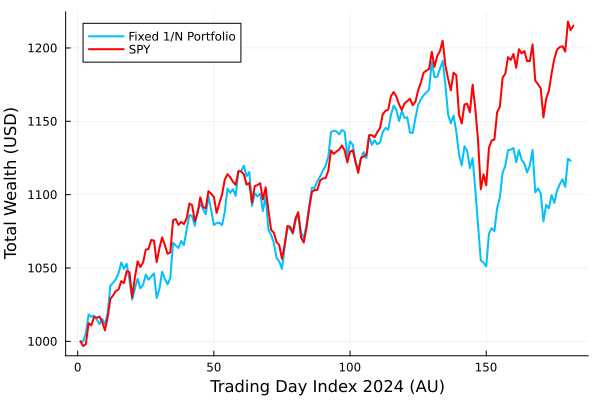

In [32]:
let
    plot(wealth_array_fixed[1:(number_of_trading_days - 1),end], lw=2, c=:deepskyblue1, label="Fixed 1/N Portfolio")
    plot!(n_spy*S_spy, c=:red, lw=2, label="SPY")
    xlabel!("Trading Day Index 2024 (AU)", fontsize=18);
    ylabel!("Total Wealth (USD)", fontsize=18)
end

`Unihide` the code block below to see how we plotted the relative risk for the portfolio $\mathcal{P}$ for each period in the out-of-sample dataset.
* __Summary__: The horizontal axis is the trading day index, while the vertical axis holds the portfolio relative risk parameter $\beta_{\mathcal{P}}$. The blue line denotes the realized risk computed at the close of each trading period, while the gray line denotes the initial risk value. The gray region represents the $\pm\,\epsilon$ region around the initial portfolio risk. Depending upon your choices of tickers in the portfolio $\mathcal{P}$, the realized risk could differ significantly from the desired risk value, i.e., it is outside of the gray region.

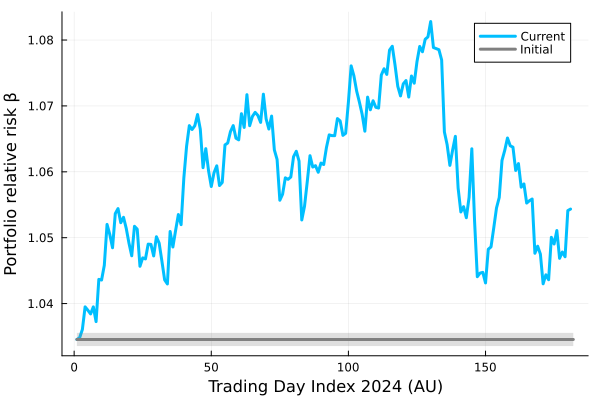

In [34]:
let
    LINE = β*ones(number_of_trading_days);
    U = LINE .+ ϵ;
    L = LINE .- ϵ;
    
    plot(beta_array_fixed, c=:deepskyblue1, lw=3, label="Current")
    plot!(LINE, fillrange=U, c=:gray, fillalpha=0.25, label="")
    plot!(LINE, fillrange=L, c=:gray, fillalpha=0.25, label="")
    plot!(LINE, c=:gray, lw=3, label="Initial")
    xlabel!("Trading Day Index 2024 (AU)", fontsize=18)
    ylabel!("Portfolio relative risk β", fontsize=18);
end

## Task 2: Equally Weighted Portfolio Allocation with Reallocation
In this task, we'll implement a reallocation algorithm that monitors the daily portfolio relative risk $\hat{\beta}_{\mathcal{P}}$ and use this value to trigger reallocation, where we'll use an equally weighted strategy.
* __Strategy__: We'll compute the desired portfolio risk $\beta_{\mathcal{P}}$ based on the initial allocation. Then, as new market data becomes available, we'll compare the new portfolio risk $\hat{\beta}_{\mathcal{P}}$ with the desired value. If they differ by more than some tolerance $\epsilon\geq{0}$, we'll liquidate the portfolio and reallocate.

`Unhide` the code block to see how we simulated the performance of the equally weighted portfolio starting from `startdate::Date` and ending on the last day of data available in the out-of-sample dataset. 
* __How is this block different__? This block is similar to the fixed allocation example above. However, he has reallocation logic starting on `L38`. We test the difference between the desired and realized portfolio relative risks; if we exceed a threshold, then we rebalance the portfolio.

In [37]:
(wealth_array_variable, omega_array_variable, beta_array_variable) = let

    # initialize storage 
    wealth_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); # last col is the total
    omega_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); 
    beta_array = Array{Float64,1}(undef, number_of_trading_days - 1);

    Nᵢ = copy(Nₒ); 

    for i = 1:(number_of_trading_days - 1)
    
        # --- SAME AS CONSTANT ALLOCATION ------------------------------------------------------------------------- #
        # get the close price array for day i
        close_price_array = market(out_of_sample_dataset, my_list_of_tickers, i); # gets the close price for today
        
        # compute the wealth array -
        for j ∈ eachindex(my_list_of_tickers)
           wealth_array[i,j] = Nᵢ[j]*close_price_array[j];
        end
        wealth_array[i,end] = sum(wealth_array[i,1:end-1]);

        # compute the omega array -
        for j ∈ eachindex(my_list_of_tickers)
            omega_array[i,j] = wealth_array[i,j]/(wealth_array[i,end])
        end
        omega_array[i,end] = sum(omega_array[i,1:end-1]);

        # compute beta -
        beta = 0.0
        for j ∈ eachindex(my_list_of_tickers)
            ticker = my_list_of_tickers[j];
            βᵢ = sim_model_dictionary[ticker].β;
            beta += omega_array[i,j]*βᵢ;
        end
        beta_array[i] = beta;
        # ------------------------------------------------------------------------------------------------------- #

        # - NEW ------------------------------------------------------------------------------------------------- #
        βᵢ = beta_array[i];
        if (abs(βᵢ-β) ≥ ϵ)

            # Ok: we are outside the risk range I'm comfortable with. Let's sell the portfolio at close and reallocate
            my_new_total_budget = wealth_array[i,end]; # budget
            next_price_array = market(out_of_sample_dataset, my_list_of_tickers, i, key = :close); # gets the close price for today

            for j ∈ eachindex(my_list_of_tickers)
                wᵢ = 1/N; # equal weight allocation
                Nᵢ[j] = (wᵢ*my_new_total_budget)/next_price_array[j]; # reallocate
            end
        end
        # ------------------------------------------------------------------------------------------------------- #
    end

    wealth_array,omega_array,beta_array
end;

#### Visualize
`Unihide` the code block below to see how we plotted the relative risk for the portfolio $\mathcal{P}$ for each period in the out-of-sample dataset in the presence of rebalancing.
* __Summary__: The horizontal axis is the trading day index, while the vertical axis holds the portfolio relative risk parameter $\beta_{\mathcal{P}}$. The blue line denotes the realized portfolio risk computed at the close of each trading period, while the gray line denotes the initial risk value. The gray region represents the $\pm\,\epsilon$ region around the initial portfolio risk. In the presence of rebalancing the realized portfolio risk much closer the desired risk zone (gray region).

In [39]:
let

    
    
    p = plot(foreground_color_axis=:white, 
        foreground_color_grid="white", framestyle = :box, bg = :black,
        foreground_color_border = :white, legend_font_color = :white, legend_background_color=:black,
        fg_legend = :transparent, foreground_color=:white, foreground_color_text=:white,
        yguidefontcolor=:white, xguidefontcolor=:white, lw=4, legend=:topleft);
    
    
    LINE = β*ones(number_of_trading_days);
    U = LINE .+ ϵ;
    L = LINE .- ϵ;
    
    plot!(LINE, fillrange=U, c=my_color_palette[4], fillalpha=1.0, label="")
    plot!(LINE, fillrange=L, c=my_color_palette[4], fillalpha=1.0, label="")
    plot!(LINE, c=:white, lw=3, label="Initial (desired)")
    plot!(U, c=:white, label="", ls=:dash)
    plot!(L, c=:white, label="", ls=:dash)
    plot!(beta_array_variable, c=:deepskyblue1, lw=3, linetype=:steppost, label="", legend=:bottomleft)
    scatter!(beta_array_variable, c=:white, label="Current (rebalanced)")
    xlabel!("Trading Day Index 2024", fontsize=18)
    ylabel!("Relative Portfolio Risk β", fontsize=18);

    # dump to disk -
    savefig(joinpath(_PATH_TO_FIGS, "Fig-Rebalaned-equal-weight-P3-Tight-OOS-2024.pdf"))
end

"/Users/jeffreyvarner/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-8/L8c/figs/Fig-Rebalaned-equal-weight-P3-Tight-OOS-2024.pdf"

`Unhide` the code block below to see how we plotted the wealth for the fixed, rebalanced, and alternative investment for the out-of-sample dataset.
* __Summary__: The horizontal axis is the trading day index, while the vertical axis is the total liquidation value of the portfolio $\mathcal{P}$ with and without rebalancing or the alternative investment. The light blue line shows the value of your equally weighted portfolio without rebalancing, the dark blue line shows the rebalanced case, and the red line shows the value of the alternative investment, in this case, `SPY.`
* Depending upon the choice of tickers in the portfolio, the fixed and rebalanced portfolios may (or may not) outperform `SPY.`

In [41]:
let

   p = plot(foreground_color_axis=:white, 
        foreground_color_grid="white", framestyle = :box, bg = :black,
        foreground_color_border = :white, legend_font_color = :white, legend_background_color=:black,
        fg_legend = :transparent, foreground_color=:white, foreground_color_text=:white,
        yguidefontcolor=:white, xguidefontcolor=:white, lw=4, legend=:topleft);
    
    
    plot!(wealth_array_variable[:,end], lw=2, c=:white, label="Rebalanced")
    plot!(wealth_array_fixed[:,end], lw=2, c=:deepskyblue1, label="Fixed")
    plot!(n_spy*S_spy, c=:red, lw=2, label="SPY")
    xlabel!("Trading Day Index 2024 (AU)", fontsize=18);
    ylabel!("Total Wealth (USD)", fontsize=18)

    # dump to disk -
    savefig(joinpath(_PATH_TO_FIGS, "Fig-Rebalaned-equal-weight-Wealth-P3-Tight-OOS-2024.pdf"))
end

"/Users/jeffreyvarner/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-8/L8c/figs/Fig-Rebalaned-equal-weight-Wealth-P3-Tight-OOS-2024.pdf"

## Task 3: Comparison of Fixed versus Reallocated Portfolio Net Present Values
In this task, we compare the net present value (NPV) for the fixed allocation portfolio, the rebalanced portfolio, and then the alternative investment, in this case, the [SP500 ETF `SPY`](https://finance.yahoo.com/quote/SPY/). Suppose we intially invest wealth $W_{\mathcal{P}}(0)$ (units: USD) in a portfolio $\mathcal{P}$ at time $t_{\circ} = 0$. Then, the net present value (NPV) of the portfolio $\mathcal{P}$ at time $T$ is given by:
$$
\begin{equation*}
\texttt{NPV}(\bar{r}, T) = -W_{\mathcal{P}}(0) + 
W_{\mathcal{P}}(T)\cdot\mathcal{D}_{T,0}^{-1}(\bar{r})
\end{equation*}
$$
where $\mathcal{D}_{T,0}(\bar{r})$ denotes the continuous discount factor, $\bar{r}$ denotes the discount rate and the wealth of the portfolio $\mathcal{P}$ at any time $t$ is given by:
$$
\begin{equation*}
W_{\mathcal{P}}(t) = \sum_{a\in\mathcal{P}}n_{a}(t)\cdot{S}_{a}(t)
\end{equation*}
$$
where $n_{a}(t)$ is the number shares of asset $a\in\mathcal{P}$ held at $t$, and $S_{a}(t)$ denotes the share price of asset $a\in\mathcal{P}$ at $t$. 
Dividing by the initial wealth gives the scaled NPV of $\mathcal{P}$:
$$
\begin{equation*}
\frac{\texttt{NPV}(\bar{r},T)}{W_{\mathcal{P}}(0)} = \left[\frac{W_{\mathcal{P}}(T)}{W_{\mathcal{P}}(0)}\right]\cdot\mathcal{D}_{T,0}^{-1}(\bar{r}) - 1
\end{equation*}
$$

Let's begin by formulating the discount function $\mathcal{D}$. Here we assume continuous discounting:

In [43]:
𝒟(r̄,t) = exp(r̄*t); # continuous discount factor

#### NPV rule: How big of a contribution does discounting make? 
Previously, when we developed the various versions of the net present value (NPV) trade rule, we ignored the role of the discount factor. For shorter-duration trades, this was a reasonable assumption. However, when we hold a portfolio for (potentially) up to a year or more, this may introduce error. Let's compute the discount factor, invert it, and see the value.
* The discount rate $\bar{r}$ will be the risk-free rate of return, while the duration $T = i\cdot\Delta{t}$, where $i$ is the trading day index, and $\Delta{t}$ is the duration of a trading day (units: years). We compute $\mathcal{D}(\bar{r},T)^{-1}$, and then use the [Julia pipe operator `|>`](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) to pipe that value into [a `println(...)` statement](https://docs.julialang.org/en/v1/base/io-network/#Base.println). 

In [45]:
(1/𝒟(risk_free_rate, (number_of_trading_days)*Δt)) |> x -> println("The 1/DF term has a value of: $(x)")

The 1/DF term has a value of: 0.9722965344587556


Next, let's compute the scaled NPV for each portfolio. We capture the NPV data in the `NPV_array::Array{Float64,1}` array, where index `1` is the fixed portfolio, index `2` is the rebalanced portfolio, and index `3` is the alternative investment, i.e., `SPY.`

In [47]:
NPV_array = let

    # initialize -
    endpoint_index = number_of_trading_days - 1;
    NPV_array = Array{Float64,1}(undef, 3); 
    r̄ = risk_free_rate;
    T = (endpoint_index)*Δt; # what is the value at the last trading 
    W_SPY = n_spy*S_spy[endpoint_index];  # wealth SPY
    
    # Compute the NPV array -
    NPV_array[1] = (wealth_array_fixed[endpoint_index,end]/wealth_array_fixed[1,end])*(1/𝒟(r̄,T)) - 1 ; # 1: fixed portfolio
    NPV_array[2] = (wealth_array_variable[endpoint_index,end]/wealth_array_variable[1,end])*(1/𝒟(r̄,T)) - 1; # 2: rebalanced portfolio
    NPV_array[3] = (W_SPY/my_total_budget)*(1/𝒟(r̄,T)) - 1; # 3: SPY 
    
    # return -
    NPV_array; 
end;

In [48]:
NPV_array

3-element Vector{Float64}:
 0.09217865232175759
 0.1078361396369305
 0.17876405246321125

#### Which approach should we use?
The largest value of the NPV suggests which strategy we should have selected. We [use the `argmax(...)` function](https://docs.julialang.org/en/v1/base/collections/#Base.argmax) to find the index of the largest value, and then pass this index to the `labels::Dict{Int, String}` dictionary which maps the index to the description of each investment.

In [50]:
labels = Dict{Int, String}(1 => "fixed", 2 => "rebalanced", 3 => "SPY");
argmax(NPV_array) |> i -> labels[i]

"SPY"

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.